In [1]:
import os
from glob import glob
import numpy as np
import dask
import xarray as xr
import xrft
import cartopy.crs as ccrs
from cmocean import cm
import h5py

from matplotlib import pyplot as plt
%matplotlib inline

from mitequinox.utils import *

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
from dask_jobqueue import PBSCluster
local_dir = os.getenv('TMPDIR')
cluster = PBSCluster(local_directory=local_dir)
#print(cluster.job_script())
w = cluster.start_workers(17)

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/distributed/utils.py:128: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [Errno 101] Network is unreachable
  % (host, default, e), RuntimeWarning)


In [3]:
# get dask handles and check dask server status
from dask.distributed import Client
client = Client(cluster)

In [4]:
client

Client Scheduler: tcp://10.148.1.19:36300 Dashboard: http://10.148.1.19:8787/status,Cluster Workers: 34 Cores: 136 Memory: 1700.00 GB


---


# 1. Drifter data files

In [19]:
# The prcessed dataset includes both the GPS- and Argo-tracked surface drifters.
# 2-month blocks with overlapping by 50%

data_dir = '/home1/datawork/xyu/Drifters/drifter_data_v1.02/'

drifter_dataset = h5py.File(data_dir+'Drifter_dataset_processed.mat','r') 
list(drifter_dataset.items())

# mlat2: mean latitude over 60 days,     157978*1
# mlon2: mean longitude over 60 days,    157978*1

# qd: drogued drifters,                  157978*1
# qmed200: median water depth > 200 m,   157978*1
# qu: undrogued drifters,                157978*1

# uv2: (u, v),                           157978*1440

[('dpth2', <HDF5 dataset "dpth2": shape (157978, 1440), type "<f8">),
 ('mdpth', <HDF5 dataset "mdpth": shape (157978, 1), type "<f8">),
 ('mlat2', <HDF5 dataset "mlat2": shape (157978, 1), type "<f8">),
 ('mlon2', <HDF5 dataset "mlon2": shape (157978, 1), type "<f8">),
 ('qall1000', <HDF5 dataset "qall1000": shape (157978, 1), type "|u1">),
 ('qall200', <HDF5 dataset "qall200": shape (157978, 1), type "|u1">),
 ('qall500', <HDF5 dataset "qall500": shape (157978, 1), type "|u1">),
 ('qd', <HDF5 dataset "qd": shape (157978, 1), type "|u1">),
 ('qmed1000', <HDF5 dataset "qmed1000": shape (157978, 1), type "|u1">),
 ('qmed200', <HDF5 dataset "qmed200": shape (157978, 1), type "|u1">),
 ('qmed500', <HDF5 dataset "qmed500": shape (157978, 1), type "|u1">),
 ('qu', <HDF5 dataset "qu": shape (157978, 1), type "|u1">),
 ('u2_err', <HDF5 dataset "u2_err": shape (157978, 1440), type "<f8">),
 ('uv2', <HDF5 dataset "uv2": shape (157978, 1440), type "|V16">),
 ('v2_err', <HDF5 dataset "v2_err": sh

In [20]:
# turn mean-lat into xarray_DataArray
lat2 = drifter_dataset['mlat2']
lat2 = np.array(lat2)
lat = xr.DataArray(lat2, dims=['lat', 'none'])
lat = xr.DataArray.squeeze(lat, dim='none')
lat = np.real(lat).rename('lat')
lat

<xarray.DataArray 'lat' (lat: 157978)>
array([ 44.219853,  44.908928,  44.856863, ..., -37.524563, -37.171366,
       -37.194084])
Dimensions without coordinates: lat

In [21]:
# turn mean-lat into xarray_DataArray
lon2 = drifter_dataset['mlon2']
lon2 = np.array(lon2)
lon = xr.DataArray(lon2, dims=['lon', 'none'])
lon = xr.DataArray.squeeze(lon, dim='none')
lon = np.real(lon).rename('lon')
lon

<xarray.DataArray 'lon' (lon: 157978)>
array([307.992707, 306.962722, 305.597501, ..., 325.844828, 326.138668,
       325.506414])
Dimensions without coordinates: lon

In [22]:
# turn drogued_information into xarray_DataArray
qd = drifter_dataset['qd']
qd = np.array(qd)
qd = xr.DataArray(qd, dims=['qd', 'none'])
qd = xr.DataArray.squeeze(qd, dim='none')
qd = np.real(qd).rename('qd')
qd

<xarray.DataArray 'qd' (qd: 157978)>
array([1, 1, 1, ..., 1, 1, 1], dtype=uint8)
Dimensions without coordinates: qd

In [23]:
# (u,v) --> u+iv
uv = drifter_dataset['uv2'].value.view(np.double).reshape((157978, 1440, 2))
uv_drifters = uv[:,:,0] + 1j*uv[:,:,1]
uv_drifters.shape  # result is (10, 10, 10)
uv_drifters

array([[-0.2048+0.4936j, -0.3023+0.4859j, -0.2971+0.4856j, ...,
         0.1322+0.009j ,  0.1219-0.0239j, -0.0805-0.1172j],
       [ 0.1436+0.2085j,  0.1056+0.1783j,  0.0387+0.128j , ...,
         0.116 +0.075j ,  0.0779+0.2255j,  0.1379+0.195j ],
       [-0.1518-0.1663j, -0.1137-0.1704j, -0.1083-0.1446j, ...,
        -0.2145-0.3872j, -0.215 -0.3862j, -0.2145-0.3976j],
       ...,
       [ 0.3967+0.1554j,  0.4447+0.1624j,  0.4864+0.1736j, ...,
         0.072 +0.2357j,  0.0712+0.2299j,  0.0676+0.2051j],
       [ 0.1061+0.0992j,  0.074 +0.0919j,  0.0629+0.096j , ...,
         0.0589+0.0466j,  0.0513+0.0552j,  0.0395+0.0682j],
       [ 0.0622+0.164j ,  0.0589+0.1348j,  0.0671+0.121j , ...,
        -0.1189+0.0092j, -0.1027-0.0244j, -0.0739-0.0525j]])

In [24]:
u_drifters = uv[:,:,0]

In [25]:
# turn drogued_information into xarray_DataArray
u2_err = drifter_dataset['u2_err']
u2_err = np.array(u2_err)

In [26]:
# Drifter Dataset (u+iv,lat,qd,time)
ds = xr.Dataset({'uv_drifters': (['lat', 'time'], uv_drifters),
                'u_drifters': (['lat', 'time'], u_drifters),
                'u_err': (['lat', 'time'], u2_err)},
                 coords={'lat': (['lat'], lat),
                         'lon': (['lat'], lon),
                         'time':(['time'], np.arange(1440)*3600),
                         'qd':(['lat'], qd)})
print(ds)
print('\n data size: %.1f GB' %(ds.nbytes / 1e9))

<xarray.Dataset>
Dimensions:      (lat: 157978, time: 1440)
Coordinates:
  * lat          (lat) float64 44.22 44.91 44.86 43.76 42.22 46.44 46.08 ...
    lon          (lat) float64 308.0 307.0 305.6 305.5 309.8 307.8 307.6 ...
  * time         (time) int64 0 3600 7200 10800 14400 18000 21600 25200 ...
    qd           (lat) uint8 1 1 1 1 1 0 0 0 1 1 0 0 0 0 0 0 0 1 1 1 0 0 0 0 ...
Data variables:
    uv_drifters  (lat, time) complex128 (-0.2048+0.4936j) (-0.3023+0.4859j) ...
    u_drifters   (lat, time) float64 -0.2048 -0.3023 -0.2971 -0.2882 -0.2168 ...
    u_err        (lat, time) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...

 data size: 7.3 GB


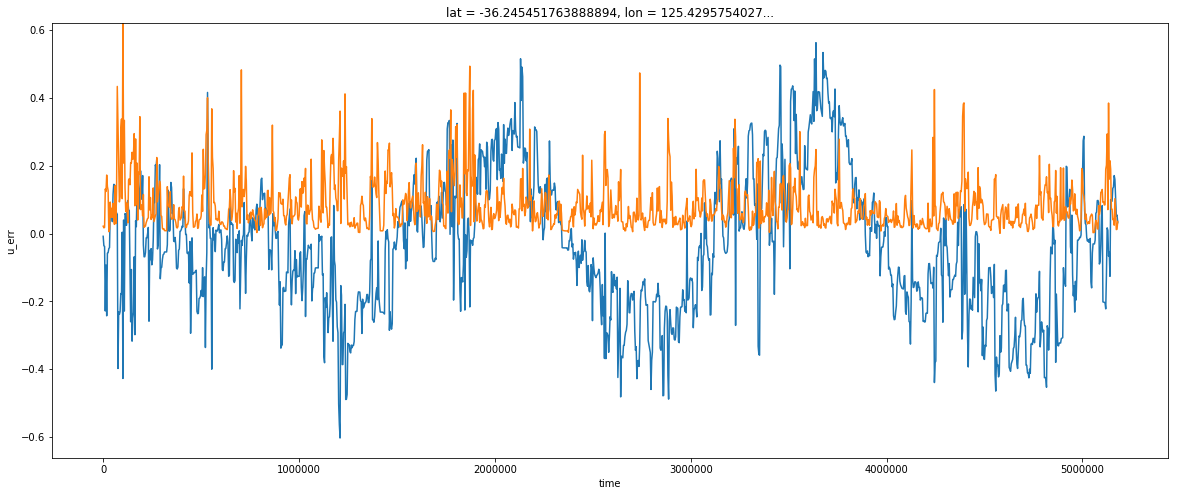

In [27]:
fig, ax = plt.subplots(figsize=(20,8))
ds.u_drifters.isel(lat=100).plot()
ds.u_err.isel(lat=100).plot()

In [28]:
uv_fft_complex = xrft.dft(ds.u_err.where(ds.qd>0).fillna(0.), dim=['time'], shift=False, detrend='linear', window=True, chunks_to_segments=False)

E_uv_blocks = (uv_fft_complex*uv_fft_complex.conj()).where(uv_fft_complex!=0., drop=False)/1440*3600
E_uv_blocks = np.real(E_uv_blocks).rename('E_uv_blocks')
E_uv_blocks = E_uv_blocks.assign_coords(freq_cpd=E_uv_blocks.freq_time * 86400.) 
E_uv_zonmean = (E_uv_blocks.groupby_bins(E_uv_blocks.lat, np.arange(-60.5, 61, 1), labels=np.arange(-60, 61, 1)).mean(dim=['lat']))

E_drifter_linear_window = E_uv_zonmean#.load()
E_drifter_linear_window = np.real(E_drifter_linear_window).rename('E_drifter_linear_window')
file_E = data_dir+'E_drifter_err_linear_window.zarr'
%time E_drifter_linear_window.to_dataset().to_zarr(file_E, mode='w')  

CPU times: user 4.64 s, sys: 264 ms, total: 4.91 s
Wall time: 1.51 s


In [29]:
# cyclonic spectra
E_uv_1 = ((E_uv_blocks).where( (E_uv_blocks.lat>0.) & (E_uv_blocks.freq_time>0.) )).mean(dim=('lat'))   
E_uv_1 = np.real(E_uv_1).rename('E_uv_1')
E_uv_1 

E_uv_2 = ((E_uv_blocks).where( (E_uv_blocks.lat<0.) & (E_uv_blocks.freq_time<0.) )).mean(dim=('lat'))   
E_uv_2 = E_uv_2.assign_coords(freq_time=E_uv_2.freq_time * -1.) 
E_uv_2 = np.real(E_uv_2).rename('E_uv_2')
E_uv_2 

E_drifter_cycl = (E_uv_1 + E_uv_2)/8.64 #(unit:cm^2 s^-2/cpd)
E_drifter_cycl = E_drifter_cycl.assign_coords(freq_time=E_drifter_cycl.freq_time * 86400.) 
E_drifter_cycl

<xarray.DataArray (freq_time: 1439)>
array([           nan, 1115546.199249, 1358239.454846, ...,            nan,
                  nan,            nan])
Coordinates:
  * freq_time          (freq_time) float64 -0.0 0.01667 0.03333 0.05 0.06667 ...
    freq_time_spacing  float64 1.929e-07

In [30]:
# anti-cyclonic spectra
E_uv_3 = ((E_uv_blocks).where( (E_uv_blocks.lat<0.) & (E_uv_blocks.freq_time>0.) )).mean(dim=('lat'))   
E_uv_3 = np.real(E_uv_3).rename('E_uv_3') 

E_uv_4 = ((E_uv_blocks).where( (E_uv_blocks.lat>0.) & (E_uv_blocks.freq_time<0.) )).mean(dim=('lat'))   
E_uv_4 = E_uv_4.assign_coords(freq_time=E_uv_4.freq_time * -1.) 
E_uv_4 = np.real(E_uv_4).rename('E_uv_4')
E_uv_4 

E_drifter_anti = (E_uv_3 + E_uv_4)/8.64 #(unit:cm^2 s^-2/cpd)
E_drifter_anti = E_drifter_anti.assign_coords(freq_time=E_drifter_anti.freq_time * 86400.) 
E_drifter_anti

<xarray.DataArray (freq_time: 1439)>
array([           nan, 1115546.199249, 1358239.454846, ...,            nan,
                  nan,            nan])
Coordinates:
  * freq_time          (freq_time) float64 -0.0 0.01667 0.03333 0.05 0.06667 ...
    freq_time_spacing  float64 1.929e-07

# 4. Plots

Text(0.5,1,'Drifters')

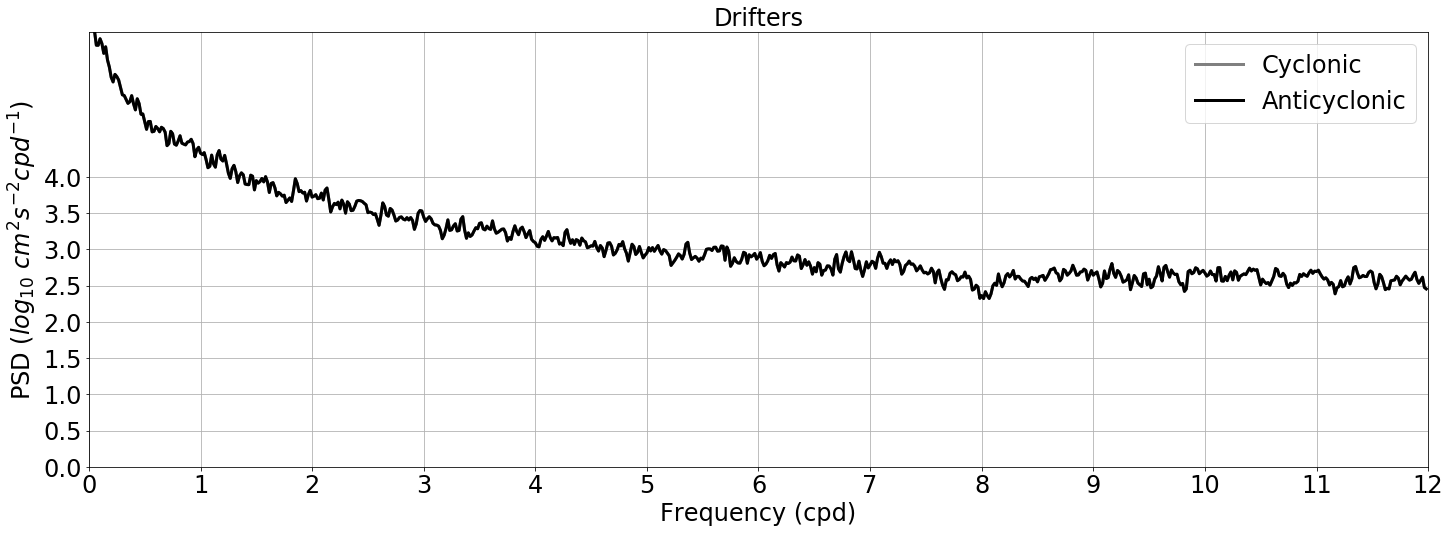

In [32]:
fig, ax = plt.subplots(figsize=(24,8))

labels = ['Cyclonic', 'Anticyclonic']

np.log10(E_drifter_cycl).plot(ax=ax, linewidth=3, color='grey', label=labels[0])
np.log10(E_drifter_anti).plot(ax=ax, linewidth=3, color='black', label=labels[1])

ax.legend(); ax.grid()
ax.set_ylim([2.,6])
ax.set_yticks([0., 0.5, 1., 1.5, 2., 2.5, 3., 3.5,4.])
ax.set_xlim([0.,12.])

ax.set_xticks([0., 1., 2., 3., 4., 5., 6., 7., 8., 9., 10., 11., 12.])
ax.legend(prop={'size': 24})
ax.set_ylabel('PSD ($log_{10}\ cm^2 s^{-2} cpd^{-1})$',fontsize=24)
ax.set_xlabel('Frequency (cpd)',fontsize=24)
ax.tick_params(labelsize=24)
ax.set_title('Drifters',fontsize=24)

#plt.savefig('/home1/datahome/xyu/equinox_working/sandbox/Figures/Rotary_spectra_globally_averaged.png')

In [34]:
cluster.scheduler.close()

<Future finished result=None>